In [9]:
import sys 
import os

if 'fast_shapelets' not in [el.split('/')[-1] for el in sys.path]:
    curr_path = os.getcwd()
    sys.path.append('/'.join((curr_path.split('/')[:-1])))

In [10]:
from src import get_dataset, sax

In [11]:
X_train,y_train, X_test, y_test = get_dataset('StarLightCurves')
y_train = y_train-1
y_test = y_test-1

Dataset StarLightCurves loading from cache 



In [12]:
X = X_train[:500]
y = y_train[:500]

In [13]:
class Shapelet:
    def __init__(self, value, initial_sample_id = None, start_initial_sample = None, gain = None, gap = None):
        self.value = value
        self.gain = gain
        self.gap = gap
        self.initial_sample = initial_sample_id
        self.start_initial_sample = start_initial_sample



In [16]:
from typing import Tuple

import jax.numpy as jnp
from jax import jit, vmap
from numpy.lib.stride_tricks import sliding_window_view
import numpy as np
def sliding_window_view_jax(x: jax.Array, window_shape:int, axis:int=-1) -> jax.Array:
    """
    Creates a sliding window view of an array.

    :param x: The input array to create a sliding window view of.
    :param window_shape: The shape of the sliding window.
    :return: The sliding window view of the input array.
    """
    reshaped = sliding_window_view(np.array(x), window_shape, axis=axis)



    return jnp.array(reshaped)

In [41]:
import numpy as np
#from jax.lax import sliding_window_view
from tqdm import tqdm

from src._sax import sax
from src._utils import get_random_hash,norm_euclidean,DTW, inverse_map, scale
from src._split import Split

import jax.numpy as jnp
import jax


def min_dist_to_shapelet(X, shapelet, dist_shapelet):
    return jnp.min(dist_shapelet(sliding_window_view_jax(X, len(shapelet), axis=1), shapelet), axis=-1)

def compute_all_distances_to_shapelet(X, shapelets, dist_shapelet):
    distances_array = np.zeros((X.shape[0], shapelets.shape[0]))
    for i, shapelet in enumerate(shapelets):
        distances_array[:,i]  = min_dist_to_shapelet(X, shapelet, dist_shapelet)
    return distances_array

compute_all_distances_to_shapelet_jitted = jax.jit(compute_all_distances_to_shapelet)
compute_all_distances_to_shapelet_opt = jax.vmap(compute_all_distances_to_shapelet, in_axes=(0, None, None))

def norm_euclidean(x, y):
    return jnp.sqrt(jnp.mean((x - y) ** 2, axis=-1))

norm_euclidean = jax.vmap(norm_euclidean, in_axes=(0, None))


class FastShapelets:
    def __init__(self, max_shapelet_length : int, min_shapelet_length: int =100, n_jobs=1, verbose=0, cardinality: int =10, r:int =10, dimensionality :int = 16):

        self.max_shapelet_length = max_shapelet_length
        self.min_shapelet_length = min_shapelet_length
        self.n_jobs = n_jobs
        self.verbose = verbose
        self.cardinality = cardinality
        self.r = r
        self.dimensionality = dimensionality


    @staticmethod
    def _compute_collision_table(sax_strings: np.ndarray, r: int = 10) -> np.ndarray:
        """
        Computes a collision table for the given SAX strings.

        :param sax_strings: The SAX strings to compute the collision table for.
        :return: The collision table.
        """


        objs = []
        map_idxs = []
        for multiple_sax_string in sax_strings:
            unique_strings, idxs = jnp.unique(multiple_sax_string, axis=0, return_index=True)

            objs.append(unique_strings)
            map_idxs.append(idxs)


            # = [(str1_obj1, str2_obj1), (str1_obj2, str2_obj2), ...]
        n_different_string = sum(obj.shape[0] for obj in objs) 
        #idx_table = jnp.concatenate([jnp.array([i] * len(obj)) for i, obj in enumerate(objs)]) # = [0, 0, 1, 1, ...]
        # idx_table = np.zeros_like(collision_table)

        collision_table = np.zeros((n_different_string, len(objs)), dtype=np.int32)
        #idx_table = jnp.concatenate([jnp.array([[0]*max(0, i-1) + [1] + [0]*(len(objs)-i)] * len(obj)) for i, obj in enumerate(objs)], axis=0)
        idx_table = np.zeros_like(collision_table)
        idx = 0

        for i, obj in enumerate(objs):
            idx_table[idx:idx+len(obj), i]=1
            idx += len(obj)

        idx_table = jnp.array(idx_table)

        objs = jnp.concatenate(objs, axis=0)

        random_hashes = jnp.array(get_random_hash(objs.shape[1], r)).T

        print('here')
        for hash_mask in random_hashes:
            projected_words = objs[:, hash_mask]
            u, indices = jnp.unique(projected_words, axis=0, return_inverse=True)
            # interm = np.zeros((u.shape[0], len(objs)))
            # interm[indices, np.arange(len(indices))] = 1
            # #interm = jnp.array(interm)
            # c = interm@idx_table
            c = jnp.zeros((u.shape[0], len(objs))).at[indices, np.arange(len(indices))].set(1)@idx_table
            for i in range(c.shape[0]):
                bool_mask = indices == i
                collision_table[bool_mask, :] +=c[i]

        return collision_table, map_idxs, idx_table
    

    @staticmethod
    def _compute_distinguishing_score(
        collision_table: np.ndarray, obj_classes: int
    ) -> np.ndarray:
        """
        Computes the distinguishing score for the given collision table.

        :param collision_table: The collision table to compute the distinguishing score for.
        :param n_samples: The number of samples.
        :return: The distinguishing score.
        """

        n_classes = np.unique(obj_classes).shape[0]

        #group collision table cols by class
        
        close2ref = np.zeros((collision_table.shape[0], n_classes))        
        for cls in np.unique(obj_classes):
            close2ref[:,int(cls)] = np.sum(collision_table[:,obj_classes == cls], axis=-1)

        farRef = np.max(close2ref) - close2ref

        return np.sum(np.abs(close2ref - farRef), axis=-1)
    
    @staticmethod
    def _find_top_k(distinguishing_scores: np.ndarray, k:int = 10):
        """
        Finds the top k distinguishing scores.

        :param distinguishing_scores: The distinguishing scores to find the top k for.
        :param k: The number of top scores to return.
        :return: The top k distinguishing scores.
        """
        return np.argsort(distinguishing_scores)[-k:]
    
    @staticmethod
    def _define_splits(splits,shapelet):
        return [Split(split,shapelet) for split in splits]
    

    @staticmethod
    def _format_raw_seq(raw_data_sequences,X,dim):
        split1, split2 = np.array_split(np.hstack(raw_data_sequences), X.shape[1] % dim, axis=1)
        raw = []
        for i in range(X.shape[0]):
            raw.extend((split1[i,:], split2[i,:]))
        return raw
    


    def fit(self, X, y,dist_shapelet=norm_euclidean):

        shapelets = {}

        X_ = scale(X)

        dist_shapelet = jax.jit(dist_shapelet)
        dist_shapelet = jax.vmap(dist_shapelet, in_axes=(0, None))

        for _len in range(self.min_shapelet_length, self.max_shapelet_length + 1):
            raw_data_subsequences, tscand = self.get_candidates_shapelets(y, X_, _len)
            print("computed candidates shapelets")

        

            min_dist = compute_all_distances_to_shapelet(X_,jnp.array([a.value for a in tscand]), dist_shapelet)
            print("computed distances")
            # min_dist.shape = (n_samples, n_shapelets) #minimum distance of each shapelet to each sample
            shapelets[_len]  = self.get_best_shapelet(y, tscand, min_dist)
            print("computed best shapelets")

        self.shapelets = shapelets

    def get_best_shapelet(self, y, tscand, min_dist):
        max_gain , min_gap = np.inf, 0
        shapelet = None

        assert min_dist.shape[1] == tscand.shape[0], "min_dist.shape[0] != tscand.shape[0]"
        for k,dlist in enumerate(min_dist.T):
            splits = self._define_splits([(dlist > d).astype(int) for d in dlist],tscand[k])
            info_gain_splits = [split.info_gain(y) for split in splits]
            gaps = [split.gap(y) for split in splits]

                ### get the best split for a given shapelet

            max_gain_cand = np.argmax(info_gain_splits, keepdims=True)
            if max_gain_cand.shape[0] > 1:
                max_gap = np.argmax([gaps[m] for m in max_gain_cand])
                best_split = splits[max_gap]

            else:
                best_split = splits[max_gain_cand[0]]

                #compare the current best split with the previous best split to find the best shapelet
            if (best_split.gain < max_gain) or (best_split.gain == max_gain and best_split.gap > min_gap):
                max_gain = best_split.gain
                min_gap = best_split.gap
                shapelet = best_split.shapelet

        shapelet.gain = max_gain
        shapelet.gap = min_gap

        return shapelet

        

    def get_candidates_shapelets(self, y, X_, _len):
        raw_data_subsequences = sliding_window_view(X_,_len,axis=1)
        sax_strings = sax(raw_data_subsequences, cardinality = self.cardinality, dimensionality = self.dimensionality)
        collision_table, map_idxs, idx_table = self._compute_collision_table(sax_strings, r=self.r)
        distinguishing_scores = self._compute_distinguishing_score(collision_table, y)
        top_k = self._find_top_k(distinguishing_scores, k=10)

        tscand = np.array([Shapelet(*inverse_map(_id, idx_table=idx_table, map_idxs=map_idxs, raw_data_subsequences=raw_data_subsequences)) for _id in top_k])
        return raw_data_subsequences,tscand


    def get_shapelets(self):
        return self.shapelets
    
    def transform(self, X,dist_shapelet):
        shapelets = np.array([el.value for el in self.get_shapelets()])
        return compute_all_distances_to_shapelet(X,shapelets,dist_shapelet)


       

In [42]:
fs = FastShapelets(min_shapelet_length=200, max_shapelet_length=201, cardinality=4, dimensionality=16, r=10)

In [43]:
fs.fit(X,y)

here
computed candidates shapelets
computed distances
computed best shapelets
here
computed candidates shapelets
computed distances
computed best shapelets


In [34]:
raw_data_subsequences = sliding_window_view(scale(X),20,axis=1)
sax_strings = sax(raw_data_subsequences,)

In [35]:
X_ = scale(X)
raw_data_subsequences = sliding_window_view(X_,200,axis=1)
sax_strings = sax(raw_data_subsequences, cardinality = fs.cardinality, dimensionality = fs.dimensionality)

In [37]:
%lprun -f fs.fit fs.fit(X,y)

here
computed candidates shapelets


TypeError: Cannot interpret value of type <class 'function'> as an abstract array; it does not have a dtype attribute

In [21]:
%load_ext line_profiler

In [12]:
a = fs.get_shapelets()[100]

In [32]:
a.start_initial_sample

116

In [15]:
import matplotlib.pyplot as plt

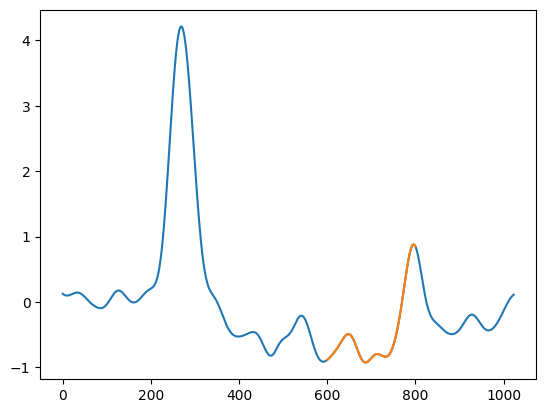

In [56]:
n  = 201
a = fs.get_shapelets()[n]
plt.plot(X[a.initial_sample])
plt.plot(np.arange(a.start_initial_sample, a.start_initial_sample+n) , a.value)

In [57]:
sliding_window_view_jax(X,100, axis=1)

Array([[[ 0.5373029 ,  0.53110296,  0.52850294, ...,  0.9014028 ,
          0.9111028 ,  0.9204028 ],
        [ 0.53110296,  0.52850294,  0.5294029 , ...,  0.9111028 ,
          0.9204028 ,  0.9292028 ],
        [ 0.52850294,  0.5294029 ,  0.53360295, ...,  0.9204028 ,
          0.9292028 ,  0.9376028 ],
        ...,
        [ 0.03910311,  0.03990311,  0.04070311, ...,  0.53720295,
          0.5323029 ,  0.52640295],
        [ 0.03990311,  0.04070311,  0.04150311, ...,  0.5323029 ,
          0.52640295,  0.51950294],
        [ 0.04070311,  0.04150311,  0.04250311, ...,  0.52640295,
          0.51950294,  0.51140296]],

       [[ 0.5883976 ,  0.5938976 ,  0.59909755, ...,  1.191595  ,
          1.195795  ,  1.199695  ],
        [ 0.5938976 ,  0.59909755,  0.60409755, ...,  1.195795  ,
          1.199695  ,  1.203095  ],
        [ 0.59909755,  0.60409755,  0.6087975 , ...,  1.199695  ,
          1.203095  ,  1.206095  ],
        ...,
        [-0.10889944, -0.10709945, -0.10459946, ...,  

In [37]:
len(fs.get_shapelets()[100].value)

100

In [30]:
def norm_euclidean(x, y):
    return jnp.mean((x - y) ** 2, axis=-1)
#norm_euclidean = jax.jit(norm_euclidean)
norm_euclidean = jax.vmap(norm_euclidean, in_axes=(0, None))

In [58]:
dist2shap_train = compute_all_distances_to_shapelet(X, np.array([fs.get_shapelets()[200].value,fs.get_shapelets()[201].value]), norm_euclidean)


/var/folders/tw/0_4t24xd3vs3yb_2z5jssqnc0000gn/T/ipykernel_57271/2490973151.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dist2shap_train = compute_all_distances_to_shapelet(X, np.array([fs.get_shapelets()[200].value,fs.get_shapelets()[201].value]), norm_euclidean)


In [59]:
dist2shap_train.shape

(500, 2)

In [62]:
dist2shap_test=  compute_all_distances_to_shapelet(X_t[:100], np.array([fs.get_shapelets()[200].value,fs.get_shapelets()[201].value]), norm_euclidean)


/var/folders/tw/0_4t24xd3vs3yb_2z5jssqnc0000gn/T/ipykernel_57271/1950199115.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dist2shap_test=  compute_all_distances_to_shapelet(X_t[:100], np.array([fs.get_shapelets()[200].value,fs.get_shapelets()[201].value]), norm_euclidean)


In [61]:
X_t = (X_test - X_test.mean(axis=1, keepdims=True)) / X_test.std(axis=1, keepdims=True)

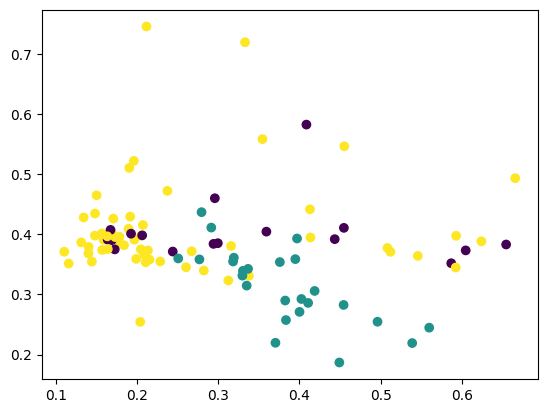

In [63]:
plt.scatter(dist2shap_test[:,0], dist2shap_test[:,1], c=y_test[:100])

In [64]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(dist2shap_train, y)
knn.score(dist2shap_test, y_test[:100])

0.67

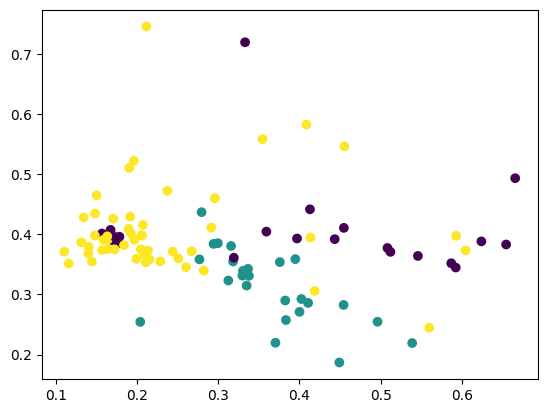

In [65]:
plt.scatter(dist2shap_test[:,0], dist2shap_test[:,1], c=knn.predict(dist2shap_test))

(0.16, 0.8329861017366056)

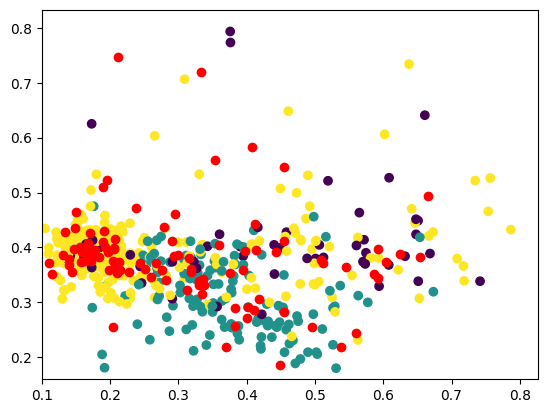

In [66]:
plt.scatter(dist2shap_train[:,0], dist2shap_train[:,1], c=y)
plt.scatter(dist2shap_test[:,0], dist2shap_test[:,1], c='r')
plt.xlim(0.10)
plt.ylim(0.16)

In [67]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test[:100], knn.predict(dist2shap_test))

0.6262204192021636

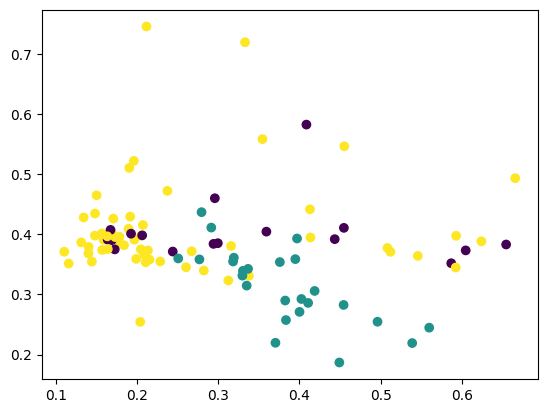

In [68]:
plt.scatter(dist2shap_test[:,0], dist2shap_test[:,1], c=y_test[:100])